# Implementing FIR filters

In real-time filtering applications, filters are implemented by using some variation or other of their constant-coefficient difference equation (CCDE), so that one new output sample is generated for each new input sample. If all input data is available in advance, as in non-real-time (aka "offline") applications, then the CCDE-based algorithm is iteratively applied to all samples in the buffer.

In the case of FIR filters, the CCDE coefficients correspond to the impulse response and implementing the CCDE is equivalent to performing a convolution sum. In this notebook we will look at different ways to implement FIR filters.

In [111]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

## Online implementation

The classic way to implement a filter is the one-in one-out approach. We will need to implement a persistent delay line. In Python we can either define a class or use function attributes; classes are tidier and reusable:

In [112]:
class FIR_loop():
    def __init__(self, h):
        self.h = h
        self.ix = 0
        self.M = len(h)
        self.buf = np.zeros(self.M)

    def filter(self, x):
        y = 0
        self.buf[self.ix] = x
        for n in range(0, self.M):
            y += self.h[n] * self.buf[(self.ix+self.M-n) % self.M]
        self.ix = (self.ix + 1) % self.M
        return y

In [113]:
# simple moving average:
h = np.ones(5)/5

f = FIR_loop(h)
for n in range(0, 10):
    print f.filter(n),

0.0 0.2 0.6 1.2 2.0 3.0 4.0 5.0 6.0 7.0


While there's nothing wrong with the above implementation, when the data to be filtered is known in advance, it makes no sense to explicitly iterate over its element and it's better to use higher-level commands to perform the convolution. In Numpy, the command is `convolve`; before we use it, though, we need to take border effects into consideration.

## Offline implementations: border effects

When filtering a finite-length data vector with a finite-length impulse response, we need to decide what to do with the "invalid" shifts appearing in the terms of the convolution sum. Remember that, in the infinite-length case, the output is defined as

$$
    y[n] = \sum_{k=-\infty}^{\infty} h[k]x[n-k]
$$

Let's say that the impulse response is $M$ points long, so that $h[n]$ is nonzero only between $0$ and $M-1$; this means that the sum is reduced to 

$$
    y[n] = \sum_{k=0}^{M-1} h[k]x[n-k]
$$

Now assume that $x[n]$ is a length-$N$ signal, so it is defined only for $0 \leq n \le N$ (we can safely consider $N > M$, otherwise exchange the roles of $x$ and $h$). In this case, the above sum is properly defined only for $M - 1 \le n \le N-1$; for any other value of $n$, the sum will contain an element $x[n-k]$ outside of the valid range of indices for the input. 

So, if we start with an $N$-point input, we can only formally compute $N-M+1$ output samples. While this may not be a problem in some applications, it certainly is troublesome if repeated filtering operations end up "chipping away" at the signal little by little.

The solution is to "embed" the finite-length input data signal into an infinite-length sequence and, as always, the result will depend on the method we choose: finite support or periodization. (Note that the impulse response is already an infinite sequence since it's the response of the filter to the infinite sequence $\delta[n]$). 

However, the embedding will create "artificial" data points that are dependent on the chosen embedding: these data points are said to suffer from **border effects**.

Let's build a simple signal and a simple FIR filter:

signal length:  21


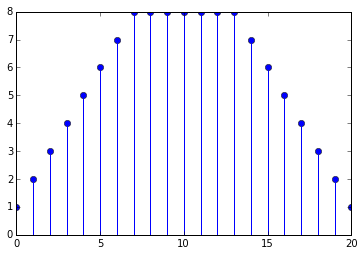

In [114]:
# let's use a simple moving average:
M = 5
h = np.ones(M)/float(M)

# let's build a signal with a ramp and a plateau
x = np.concatenate((np.arange(1, 9), np.ones(5) * 8, np.arange(8,0,-1)))
plt.stem(x);
print 'signal length: ', len(x)

### 1) No border effects

We may choose to accept the loss of data points and use only the $N-M+1$ output samples that correspond to a full overlap between the input data and the impulse response. This can be achieved by selecting `mode='valid'` in `correlate`:

signal length:  17


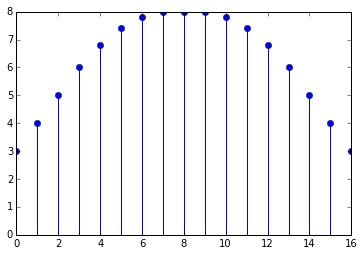

In [115]:
y = np.convolve(x, h, mode='valid')
print 'signal length: ', len(y)
plt.stem(y);

### 2) finite-support extension

By embedding the input into a finite-support signal, the convolution sum is now well defined for all values of $n$, which now creates a new problem: the output will be nonzero for all values of $n$ for which $x[n-k]$ is nonzero, that is for $0 \le n \le N+M-1$: we end up with a *longer* support for the output sequence. This is the default in `correlate`  and corresponds to `mode='full'`:

signal length:  25


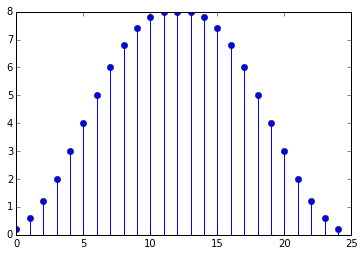

In [116]:
y = np.convolve(x, h, mode='full')
print 'signal length: ', len(y)
plt.stem(y);

If we want to preserve the same length for input and output, we need to truncate the result. You can keep the *first* $N$ samples and discard the tail; this corresponds to the online implementation of the FIR filter. Alternatively, you can discard half the extra samples from the beginning and half from the end of the output and distribute the border effect evenly; this is achieved in `correlate`  by setting `mode='same'`: 

signal length:  21


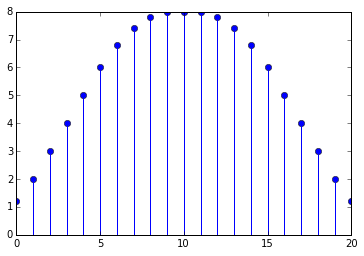

In [117]:
y = np.convolve(x, h, mode='same')
print 'signal length: ', len(y)
plt.stem(y);

### 3) Periodic extension 

As we know, the other way of embedding a finite-length signal is to build a periodic extension. The convolution in this case will return an $N$-periodic output:

$$
    \tilde{y}[n] = \sum_{k=0}^{M-1} h[k]\tilde{x}[n-k]
$$

We can easily implement a circular convolution using `convolve` like so: since the overlap between time-reversed impulse response and input is already good for the last $N-M$ points in the output, we just need to consider two periods of the input to compute the first $M$: 

In [118]:
def cconv(x, h):
    # as before, we assume len(h) < len(x)
    L = len(x)
    xp = np.concatenate((x,x))
    # full convolution
    y = np.convolve(xp, h)
    return y[L:2*L]

signal length:  21


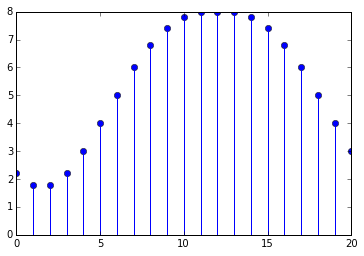

In [119]:
y = cconv(x, h)
print 'signal length: ', len(y)
plt.stem(y);

OK, clearly the result is not necessarily what we expected; note however that in both circular and "normal" convolution, you still have $M-1$ output samples "touched" by border effects, it's just that the border effects act differently in the two cases.

Interestingly, you can still obtain a "normal" convolution using a circular convolution if you zero-pad the input signal with $M-1$ zeros:

signal length:  25


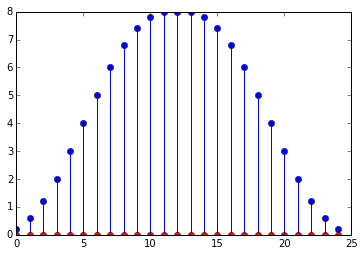

In [120]:
y = cconv(np.concatenate((x, np.zeros(M-1))), h)
print 'signal length: ', len(y)
plt.stem(y);
# plot in red the difference with the standard conv
plt.stem(y - np.convolve(x, h, mode='full'), markerfmt='ro');

Why is this interesting? Because of the DFT....

## Offline implementations using the DFT

The convolution theorem states that, for infinite sequences, 

$$
    (x\ast y)[n] = \mbox{IDTFT}\{X(e^{j\omega})Y(e^{j\omega})\}[n]
$$

Can we apply this result to the finite-length case? In other words, what is the inverse DFT of the product of two DFTs? Let's see:

\begin{align}
    \sum_{k=0}^{N-1}X[k]Y[k]e^{j\frac{2\pi}{N}nk} &= \sum_{k=0}^{N-1}\sum_{p=0}^{N-1}x[p]e^{-j\frac{2\pi}{N}pk}\sum_{q=0}^{N-1}y[q]e^{-j\frac{2\pi}{N}qk} \,e^{j\frac{2\pi}{N}nk} \\
    &= \sum_{p=0}^{N-1}\sum_{q=0}^{N-1}x[p]y[q]\sum_{k=0}^{N-1}e^{j\frac{2\pi}{N}(n-p-q)k} \\
    &= N\sum_{p=0}^{N-1}x[p]y[(n-p) \mod N]
\end{align}

The results follows from the fact that $\sum_{k=0}^{N-1}e^{j\frac{2\pi}{N}(n-p-q)k}$ is nonzero only for $n-p-q$ multiple of $N$; as $p$ varies from $0$ to $N-1$, the corresponding value of $q$ between $0$ and $N$ that makes $n-p-q$ multiple of $N$ is $(n-p) \mod N$.

So the fundamental result is: **the inverse DFT of the product of two DFTs is the circular convolution of the underlying time-domain sequences!**


To apply this result to FIR filtering, the first step is to choose the space for the DFTs. In our case we have a finite-length data vector of length $N$ and a finite-support impulse response of length $M$ with $M<N$ so let's operate in $\mathbb{C}^N$ by zero-padding the impulse response to size $N$. Also, we most likely want the normal convolution, so let's zero-pad both signals by an additional $M-1$ samples

In [121]:
def DFTconv(x, h, mode='full'):
    # we want the compute the full convolution
    N = len(x)
    M = len(h)
    X = np.fft.fft(x, n=N+M-1)
    H = np.fft.fft(h, n=N+M-1)
    # we're using real-valued signals, so drop the imaginary part
    y = np.real(np.fft.ifft(X * H))
    if mode == 'valid':
        # only N-M+1 points, starting at M-1
        return y[M-1:N]
    elif mode == 'same':
        return y[(M-1)/2:(M-1)/2+N]
    else:
        return y

Let's verify that the results are the same

signal length:  17
signal length:  17


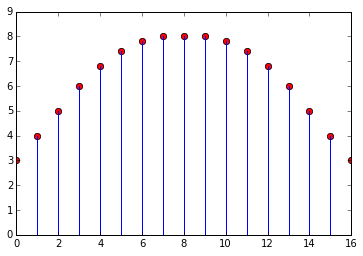

In [122]:
y = np.convolve(x, h, mode='valid')
print 'signal length: ', len(y)
plt.stem(y);
y = DFTconv(x, h, mode='valid')
print 'signal length: ', len(y)
plt.stem(y, markerfmt='ro');

signal length:  21
signal length:  21


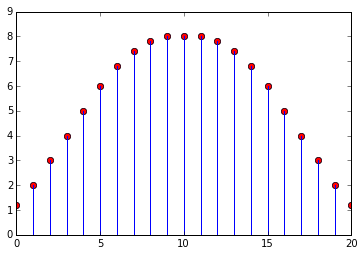

In [123]:
y = np.convolve(x, h, mode='same')
print 'signal length: ', len(y)
plt.stem(y);
y = DFTconv(x, h, mode='same')
print 'signal length: ', len(y)
plt.stem(y, markerfmt='ro');

Of course the question at this point is: why go through the trouble of taking DFTs if all we want is the standard convolution? The answer is: **computational efficiency.**

If you look at the convolution sum, each output sample requires $M$ multiplications (and $M-1$ additions but let's just consider multiplications). In order to filter an $N$-point signal we will need $NM$ multiplications. Assume $N \approx M$ and you can see that the computational requirements are on the order of $M^2$. If we go the DFT route using an efficient FFT implementation we have approximately: 

 * $M\log_2 M$ multiplication to compute $H[k]$
 * $M\log_2 M$ multiplication to compute $X[k]$
 * $M\log_2 M$ multiplication to compute $X[k]H[k]$
 * $M\log_2 M$ multiplication to compute the inverse DFT
 
Even considering that we now have to use complex multiplications (which will cost twice as much), we can estimate the cost of the DFT based convolution at around $8M\log_2M$, which is smaller than $M^2$ as soon as $M>44$.  

In practice, the data vector is much longer than the impulse response so that filtering via standard convolution requires on the order of $MN$ operations. Two techniques, called [Overlap Add](https://en.wikipedia.org/wiki/Overlap%E2%80%93add_method) and [Overlap Save](https://en.wikipedia.org/wiki/Overlap%E2%80%93save_method)
can be used to divide the convolution into $N/M$ independent convolutions between $h[n]$ and an $M$-sized piece of $x[n]$; FFT-based convolution can then be used on each piece. While the exact cost per sample of each technique is a bit complicated to estimate, as a rule of thumb **as soon as the impulse response is longer than 50 samples, it's more convenient to use DFT-based filtering.** 